<!-- ========================================================= -->
<!--        John Snow Labs - Package Installation Guide         -->
<!--        JupyterLab Single Markdown Cell (HTML Content)      -->
<!-- ========================================================= -->

<h1>Package Installation</h1>

<!-- Link to official GitHub repository -->
<p>
  Official Repository:
  <a href="https://github.com/JohnSnowLabs/johnsnowlabs" target="_blank">
    https://github.com/JohnSnowLabs/johnsnowlabs
  </a>
</p>

<!-- License setup instructions -->
<p>
  Keep your <strong>license keys</strong> in a JSON file and point to it using the
  <code>json_license_path</code> argument when starting the Spark session.
</p>

<!-- Visual NLP configuration note -->
<p>
  Set <code>visual=True</code> while starting the Spark session to install and make
  <strong>Visual NLP libraries</strong> available.
</p>

<!-- Restart note -->
<p>
  ⚠️ <strong>Important:</strong> After installing the library, make sure to
  <strong>RESTART your session</strong> before running Spark again.
</p>

<!-- End of notebook cell -->

In [ ]:
!pip install -q johnsnowlabs

In [ ]:
from johnsnowlabs import nlp, visual, medical

nlp.install(refresh_install=True, visual=True, json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

In [ ]:
### RESTART SESSION !!!

In [1]:
from johnsnowlabs import visual, nlp

spark = nlp.start(visual=True, hardware_target="gpu", json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

spark

👌 License info detected in file ./spark_nlp_for_healthcare_spark_ocr_10538.json


25/10/22 19:13:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/22 19:13:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


👌 Launched gpu optimized session with with: 🚀Spark-NLP==6.1.3, 💊Spark-Healthcare==6.1.1, 🕶Spark-OCR==6.1.0, running on ⚡ PySpark==3.4.0


<h1>Dicom Pixel DeIdentification - MIDIB</h1>

<!-- Notebook purpose -->
<p>
  This notebook demonstrates the evaluation of <strong>Pixel De-Identification</strong> performance on the <strong>MIDI-B dataset</strong>.
  The workflow involves performing <strong>OCR</strong> on the original DICOM files to extract text regions containing PHI,
  followed by applying <strong>Pixel De-Identification</strong> to remove the detected sensitive information.
  After de-identification, <strong>OCR is executed again</strong> on the anonymized images to verify that all PHI has been successfully removed.
  This two-step validation process ensures accurate and reliable assessment of the pixel de-identification pipeline.
</p>

<!-- Stages list -->
<h2>Concepts and Components Covered in this Notebook</h2>
<ul>
    <li>DicomToMetadata</li>
    <li>DicomToImageV3</li>
    <li>ImageTextDetector</li>
    <li>ImageToTextV3</li>
    <li>DicomDeidentifier</li>
    <li>PositionFinder</li>
    <li>ImageDrawRegions</li>
    <li>DicomDeidentifier</li>
    <li>DocumentAssembler</li>
    <li>SentenceDetectorDLModel</li>
    <li>Tokenizer</li>
    <li>WordEmbeddingsModel</li>
    <li>MedicalNerModel</li>
    <li>NerConverterInternal</li>
    <li>ChunkMergeApproach</li>
</ul>

## Download MIDIB Pixel Data

In [ ]:
!pip install gdown

In [10]:
!gdown 1ndhUYKgUqmhD2N4ulJs0rX2GytqhT28D -O ./data/visual/dicom/midib.zip

IOStream.flush timed out
Downloading...
From (original): https://drive.google.com/uc?id=1ndhUYKgUqmhD2N4ulJs0rX2GytqhT28D
From (redirected): https://drive.google.com/uc?id=1ndhUYKgUqmhD2N4ulJs0rX2GytqhT28D&confirm=t&uuid=f7a967ad-ead6-4e71-890f-63cbf1e7d4ac
To: /workspace/spark-nlp-workshop/tutorials/Certification_Trainings/Training_Notebooks & Slides/Visual_NLP/data/visual/dicom/midib.zip
100%|████████████████████████████████████████| 300M/300M [00:03<00:00, 90.8MB/s]


In [11]:
!unzip -q ./data/visual/dicom/midib.zip -d ./data/visual/dicom/

IOStream.flush timed out


In [12]:
!rm -rf ./data/visual/dicom/__MACOSX

IOStream.flush timed out


In [13]:
# 📦 Spark OCR Imports
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *

# ⚡ Spark NLP Core
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# 🔗 Spark ML
from pyspark.ml import Pipeline, PipelineModel
import pyspark.sql.functions as F

# 🧩 Spark NLP for Healthcare (JSL)
import sparknlp_jsl
from sparknlp_jsl.annotator import *

from IPython.display import display, Markdown

from sparkocr.base import LightPipeline
from pyspark.sql.types import *
from PIL import Image, ImageDraw, ImageFont
import pkg_resources
import pandas as pd
import time

In [17]:
dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(False)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setUseGPU(True) \
    .setWidth(0)

ocr = ImageToTextV2.pretrained("ocr_large_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False) \
    .setKeepInput(False) \
    .setUseGPU(True) \
    .setUseCaching(True) \
    .setBatchSize(4)

stages = [
    dicom_to_image,
    text_detector,
    ocr
]

dicom_ocr_pipeline = Pipeline(stages=stages)

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


25/10/22 19:24:28 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


In [18]:
dicom_source_path = "./data/visual/dicom/midib/*.dcm"
dicom_df = spark.read.format("binaryFile").load(dicom_source_path).repartition(1)

print(f"Total Dicom Files : {dicom_df.count()}")
print(f"Total Number of Partitions : {dicom_df.rdd.getNumPartitions()}")

Total Dicom Files : 25


[Stage 10:==========================================>             (15 + 5) / 20]

Total Number of Partitions : 1


In [ ]:
original_ocr_results = dicom_ocr_pipeline.fit(dicom_df).transform(dicom_df)

original_ocr_results.select("pagenum", "path", "text", "exception").repartition(25) \
    .write.format("parquet").mode("overwrite").save("./temp_ocr_results")

In [20]:
get_base_name = F.udf(lambda path: os.path.basename(path), StringType())

In [21]:
ocr_result_df = spark.read.format("parquet").load("./temp_ocr_results/")

main_ocr_df = ocr_result_df.withColumn("file_base", get_base_name(col("path"))).select("file_base", "text")

main_ocr_df.toPandas().head(50)

file_base  \
0   TCIA-MIDI-B-Synthetic-Validation_20250502___1....   
1   TCIA-MIDI-B-Synthetic-Test_20250502___1.4.964....   
2   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
3   TCIA-MIDI-B-Synthetic-Test_20250502___3.1.778....   
4   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
5   TCIA-MIDI-B-Synthetic-Test_20250502___1.3.412....   
6   TCIA-MIDI-B-Synthetic-Test_20250502___1.4.873....   
7   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
8   TCIA-MIDI-B-Synthetic-Test_20250502___1.4.722....   
9   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
10  TCIA-MIDI-B-Synthetic-Test_20250502___3.1.805....   
11  TCIA-MIDI-B-Synthetic-Test_20250502___2.3.185....   
12  TCIA-MIDI-B-Synthetic-Test_20250502___3.4.956....   
13  TCIA-MIDI-B-Synthetic-Test_20250502___2.3.233....   
14  TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
15  TCIA-MIDI-B-Synthetic-Validation_20250502___3....   
16  TCIA-MIDI-B-Synthetic-Validation_20250502___1....   
17  TCIA-MIDI-B-Synthetic-Test_20250502___2.5.568....   
18  TCIA-MIDI-B-Synthetic-Test_20250502___1.1.582....   
19  TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
20  TCIA-MIDI-B-Synthetic-Test_20250502___3.2.122....   
21  TCIA-MIDI-B-Synthetic-Test_20250502___1.2.714....   
22  TCIA-MIDI-B-Synthetic-Validation_20250502___3....   
23  TCIA-MIDI-B-Synthetic-Test_20250502___1.4.776....   
24  TCIA-MIDI-B-Synthetic-Test_20250502___3.5.621....   

                                                 text  
0   SANCHEZ TIMOTHY [M] 08.05.2018\nDOB: 07.01.197...  
1   SERVANTES CHRISTOPHER [M] 07.09.2014\nPORTABLE...  
2   R\nACH\nJAMES RUSSELL [M] 12.13.2018\nDOB: 10....  
3   PORTABLE\nJACOBS PHILLIP [M] 04.15.2015\nDOB: ...  
4   MARTIN ERIC [M] 09.20.2010\nDOB: 07.28.1938\nR...  
5   57\nL\nWEBB JOSEPH [M] 07.28.2013\nDOB: 06.09....  
6   M\nL LMCC\nS\nSAWYER MONIQUE [F] 05.09.2018\nD...  
7   101\nJOHNSON LARRY [M] 03.09.2019\nDOB: 01.30....  
8   RAY RYAN [M] 07.06.2011\nDOB: 06.03.1968\nSEMB...  
9   7\nCH1\nHAYES JESSICA [F] 01.03.2012\nDOB: 12....  
10  BIRD CHRISTOPHER [M] 12.05.2016\nDOB: 11.06.19...  
11  EDWARDS WILLIAM [M] 05.26.2019\nDOB: 03.26.193...  
12  EVANS REBECCA [F] 06.22.2014\nDOB: 04.25.1937\...  
13  WWWWWW\nGOMEZ MATTHEW [M] 10.13.2016\nDOB: 09....  
14   BELL AUSTIN [U] 02.29.2012\nDOB: 01.24.1964\nRCC  
15   GARCIA MEAGAN [F] 03.30.2013\nDOB: 02.24.1967\nD  
16    84\nADAMS LAURA [U] 10.14.2010\nDOB: 08.31.1952  
17  JOHNSON MICHELLE [F] 02.10.2012\nDOB: 01.01.19...  
18  LCC\nMENDOZA BRUCE [U] 07.20.2013\nDOB: 05.27....  
19      JONES ERIN [F] 01.12.2019\nD\nDOB: 11.12.1937  
20  D\nHANCOCK KRISTI [F] 07.16.2013\nDOB: 05.31.1951  
21  L:\nONEAL DARRELL [U] 04.13.2012\nDOB: 02.19.1940  
22        MOODY BRENT [M] 08.06.2010\nDOB: 06.01.1922  
23       TERRY ANN [F] 05.31.2013\nDOB: 04.12.1948\nD  
24        HARRIS ERIN [F] 07.06.2010\nDOB: 06.10.1975

In [ ]:
from sparknlp.pretrained import PretrainedPipeline
deid_pipeline = PretrainedPipeline("clinical_deidentification_docwise_benchmark_large", "en", "clinical/models")

In [23]:
dicom_to_metadata = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata") \
    .setKeepInput(True)

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(False)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setUseGPU(True) \
    .setWidth(0)

ocr = ImageToTextV2.pretrained("ocr_large_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False) \
    .setKeepInput(False) \
    .setUseGPU(True) \
    .setUseCaching(True) \
    .setBatchSize(4)

regex_matcher = RegexMatcher()\
    .setInputCols("document")\
    .setOutputCol("regex")\
    .setRules([
        r"(?:\s[MFU]|\b[MFU])(?:\s|\b|$);GENDER",
        r"\b(?:JT|SWU|JKR|MWF|ICG|NKF|YH|TJN|LEITO|ACO|CEF|CMS|JGR|MSS|MHS|ROC|LM|RCN|FTA|MGO|LACI|VV|HA|TR|CJA)\b;CODE"]) \
    .setDelimiter(";")

chunkConverter = ChunkConverter()\
    .setInputCols("regex")\
    .setOutputCol("regex_chunks")

chunk_merger = ChunkMergeApproach()\
    .setInputCols('regex_chunks', "ner_chunk")\
    .setOutputCol('merged_ner_chunk')\
    .setMergeOverlapping(True)

position_finder = PositionFinder() \
    .setInputCols("merged_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setSmoothCoordinates(True)

draw_regions = DicomDrawRegions() \
    .setInputCol("path") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom") \
    .setAggCols(["path"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom"]) \
    .setOutputCol("dicom_cleaned")

stages = deid_pipeline.model.stages[:-2].copy()

stages.insert(0, dicom_to_metadata)
stages.insert(1, dicom_to_image)
stages.insert(2, text_detector)
stages.insert(3, ocr)
stages.append(regex_matcher)
stages.append(chunkConverter)
stages.append(chunk_merger)
stages.append(position_finder)
stages.append(draw_regions)
stages.append(dicom_deidentifier)

dicom_phi_deid_pipeline = Pipeline(stages=stages)

image_text_detector_mem_opt download started this may take some time.


25/10/22 19:33:36 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 77.5 MB


In [24]:
deid_result = dicom_phi_deid_pipeline.fit(dicom_df).transform(dicom_df)

deid_result.columns

['dicom_cleaned', 'exception', 'path']

In [ ]:
deid_result.repartition(25).write.format("parquet").mode("overwrite").save("./deid_dicom_result/")

In [26]:
checkpoint_dicom_deid_df = spark.read.format("parquet").load("./deid_dicom_result/")

checkpoint_dicom_deid_df.select("exception").distinct().show(10, False)

+---------+
|exception|
+---------+
|         |
+---------+



In [27]:
checkpoint_dicom_deid_df.columns

['dicom_cleaned', 'exception', 'path']

In [28]:
root_save_dir = "./deid_dicom_files"

os.makedirs(root_save_dir, exist_ok=True)

for item in checkpoint_dicom_deid_df.select("path", "dicom_cleaned").toLocalIterator():
    data = item.asDict()
    filename = os.path.basename(data["path"])

    dicom_path = os.path.join(root_save_dir, filename)

    print(f"Saving Filename : {filename}")
    
    with open(dicom_path, "wb") as f:
        f.write(data["dicom_cleaned"])

[Stage 187:>                                                        (0 + 1) / 1]

Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___3.5.621.0.0.3188908.4.648.3087465043165607828___1-1.dcm


[Stage 188:>                                                        (0 + 1) / 1]

Saving Filename : TCIA-MIDI-B-Synthetic-Validation_20250502___2.4.569.0.1.8829737.8.747.1088525486356273997___1-1.dcm


[Stage 189:>                                                        (0 + 1) / 1]

Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___1.4.776.1.3.4191796.3.569.9002808596826843594___1-1.dcm


[Stage 190:>                                                        (0 + 1) / 1]

Saving Filename : TCIA-MIDI-B-Synthetic-Validation_20250502___3.3.608.1.1.2993058.8.105.1343059462659162280___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___3.1.778.1.2.2980276.4.579.1938598966739082384___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Validation_20250502___2.1.497.0.0.1835643.9.081.1307210876115091140___1-1.dcm


[Stage 193:>                                                        (0 + 1) / 1]

Saving Filename : TCIA-MIDI-B-Synthetic-Validation_20250502___2.3.568.1.0.7053673.2.382.1770839949180489836___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___1.4.964.0.0.7975941.4.754.3183774186994792142___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___1.4.873.0.3.5080754.7.663.3156523823792893657___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___2.3.233.1.0.8515474.5.043.3751234163313928298___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___1.4.722.0.2.2647229.2.918.1958496948004872432___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___3.1.805.0.0.3054685.1.073.2355356109348804927___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Validation_20250502___2.3.957.1.1.1204841.4.221.1244497244821555782___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Validation_20250502___2.1.239.0.1.5573651.5.438.2234045507897739313___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Validation_20250502___2.4.674.0.0.2358241.5.29

[Stage 204:>                                                        (0 + 1) / 1]

Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___1.3.412.1.0.6375514.4.057.2200757102939618456___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Validation_20250502___1.5.566.0.3.5921028.1.523.5821238071079767946___1-1.dcm


[Stage 205:>                                                        (0 + 1) / 1]

Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___3.4.956.1.3.8856560.9.121.3385223255730564810___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___1.1.582.0.3.8604111.4.040.1865311550435039158___1-1.dcm


[Stage 206:>                                                        (0 + 1) / 1]

Saving Filename : TCIA-MIDI-B-Synthetic-Validation_20250502___1.2.398.1.2.6768134.2.774.2820592714662272665___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___2.3.185.0.2.0801206.6.512.1517291030850877420___1-1.dcm


[Stage 207:>                                                        (0 + 1) / 1]

Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___1.2.714.0.0.7426654.9.695.1102170333010371365___1-1.dcm
Saving Filename : TCIA-MIDI-B-Synthetic-Test_20250502___3.2.122.1.2.8066147.5.661.3076430383400550560___1-1.dcm


In [29]:
dicom_source_path = "./deid_dicom_files/*.dcm"
dicom_df = spark.read.format("binaryFile").load(dicom_source_path).repartition(1)

print(f"Total Dicom Files : {dicom_df.count()}")
print(f"Total Number of Partitions : {dicom_df.rdd.getNumPartitions()}")

Total Dicom Files : 25
Total Number of Partitions : 1


In [ ]:
deid_ocr_results = dicom_ocr_pipeline.fit(dicom_df).transform(dicom_df)

deid_ocr_results.select("pagenum", "path", "text", "exception").repartition(25).write.format("parquet").mode("overwrite").save("./temp_deid_ocr_results")

In [31]:
deid_ocr_result_df = spark.read.format("parquet").load("./temp_deid_ocr_results/")

deid_ocr_df = deid_ocr_result_df.withColumn("file_base", get_base_name(col("path"))).select("file_base", "text")

deid_ocr_df.toPandas().head(25)

file_base  \
0   TCIA-MIDI-B-Synthetic-Validation_20250502___1....   
1   TCIA-MIDI-B-Synthetic-Test_20250502___3.1.778....   
2   TCIA-MIDI-B-Synthetic-Test_20250502___1.4.964....   
3   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
4   TCIA-MIDI-B-Synthetic-Test_20250502___1.3.412....   
5   TCIA-MIDI-B-Synthetic-Test_20250502___1.4.722....   
6   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
7   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
8   TCIA-MIDI-B-Synthetic-Test_20250502___1.4.873....   
9   TCIA-MIDI-B-Synthetic-Validation_20250502___1....   
10  TCIA-MIDI-B-Synthetic-Validation_20250502___3....   
11  TCIA-MIDI-B-Synthetic-Test_20250502___3.4.956....   
12  TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
13  TCIA-MIDI-B-Synthetic-Test_20250502___2.3.233....   
14  TCIA-MIDI-B-Synthetic-Validation_20250502___3....   
15  TCIA-MIDI-B-Synthetic-Test_20250502___2.5.568....   
16  TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
17  TCIA-MIDI-B-Synthetic-Test_20250502___3.1.805....   
18  TCIA-MIDI-B-Synthetic-Test_20250502___1.4.776....   
19  TCIA-MIDI-B-Synthetic-Test_20250502___1.1.582....   
20  TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
21  TCIA-MIDI-B-Synthetic-Test_20250502___2.3.185....   
22  TCIA-MIDI-B-Synthetic-Test_20250502___3.2.122....   
23  TCIA-MIDI-B-Synthetic-Test_20250502___3.5.621....   
24  TCIA-MIDI-B-Synthetic-Test_20250502___1.2.714....   

                                      text  
0   HYRM]\nDOB:\nR\nSEMI-UPRIGHT\nPORTABLE  
1         PORTABLE\n[S]\nDOB:\nPORTABLE #6  
2           ER MI\nPORTABLE\nDOB:\nUPRIGHT  
3                R\nACH\nDOB:\nPORTABLE #6  
4                57\nL\nDOB:\nSEMI-UPRIGHT  
5                IN VI\nDOB:\nSEMBRABLE\nR  
6                     101\nRY(M)\nDOB:\nRM  
7                     CJ AL\nDOB:\nRM\n***  
8                     LL LL\nRUL [F]\nDOB:  
9                         84\nRA [U]\nDOB:  
10                         AN [F]\nDOB:\nD  
11                     CA FJ\nDOB:\nTO RCC  
12                           IN I J]\nDOB:  
13                      WWWWWW\nEWIM\nDOB:  
14                             NT M]\nDOB:  
15                        LLE [F]\nDOB:\nD  
16                            7\nCH1\nDOB:  
17                        ER MI\nDOB:\nRLD  
18                          IN F]\nDOB:\nD  
19                           ICE [U]\nDOB:  
20                                 D\nDOB:  
21                             AM MI\nDOB:  
22                             TI FI\nDOB:  
23                              N FI\nDOB:  
24                                L:\nDOB:

In [33]:
joined_df = deid_ocr_df.withColumnRenamed("text", "post_deid_text").join(main_ocr_df, on="file_base", how="inner")

joined_df.toPandas().head(50)

file_base  \
0   TCIA-MIDI-B-Synthetic-Validation_20250502___1....   
1   TCIA-MIDI-B-Synthetic-Test_20250502___1.4.964....   
2   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
3   TCIA-MIDI-B-Synthetic-Test_20250502___3.1.778....   
4   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
5   TCIA-MIDI-B-Synthetic-Test_20250502___1.3.412....   
6   TCIA-MIDI-B-Synthetic-Test_20250502___1.4.873....   
7   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
8   TCIA-MIDI-B-Synthetic-Test_20250502___1.4.722....   
9   TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
10  TCIA-MIDI-B-Synthetic-Test_20250502___3.1.805....   
11  TCIA-MIDI-B-Synthetic-Test_20250502___2.3.185....   
12  TCIA-MIDI-B-Synthetic-Test_20250502___3.4.956....   
13  TCIA-MIDI-B-Synthetic-Test_20250502___2.3.233....   
14  TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
15  TCIA-MIDI-B-Synthetic-Validation_20250502___3....   
16  TCIA-MIDI-B-Synthetic-Validation_20250502___1....   
17  TCIA-MIDI-B-Synthetic-Test_20250502___2.5.568....   
18  TCIA-MIDI-B-Synthetic-Test_20250502___1.1.582....   
19  TCIA-MIDI-B-Synthetic-Validation_20250502___2....   
20  TCIA-MIDI-B-Synthetic-Test_20250502___3.2.122....   
21  TCIA-MIDI-B-Synthetic-Test_20250502___1.2.714....   
22  TCIA-MIDI-B-Synthetic-Validation_20250502___3....   
23  TCIA-MIDI-B-Synthetic-Test_20250502___1.4.776....   
24  TCIA-MIDI-B-Synthetic-Test_20250502___3.5.621....   

                            post_deid_text  \
0   HYRM]\nDOB:\nR\nSEMI-UPRIGHT\nPORTABLE   
1           ER MI\nPORTABLE\nDOB:\nUPRIGHT   
2                R\nACH\nDOB:\nPORTABLE #6   
3         PORTABLE\n[S]\nDOB:\nPORTABLE #6   
4                     CJ AL\nDOB:\nRM\n***   
5                57\nL\nDOB:\nSEMI-UPRIGHT   
6                     LL LL\nRUL [F]\nDOB:   
7                     101\nRY(M)\nDOB:\nRM   
8                IN VI\nDOB:\nSEMBRABLE\nR   
9                             7\nCH1\nDOB:   
10                        ER MI\nDOB:\nRLD   
11                             AM MI\nDOB:   
12                     CA FJ\nDOB:\nTO RCC   
13                      WWWWWW\nEWIM\nDOB:   
14                           IN I J]\nDOB:   
15                         AN [F]\nDOB:\nD   
16                        84\nRA [U]\nDOB:   
17                        LLE [F]\nDOB:\nD   
18                           ICE [U]\nDOB:   
19                                 D\nDOB:   
20                             TI FI\nDOB:   
21                                L:\nDOB:   
22                             NT M]\nDOB:   
23                          IN F]\nDOB:\nD   
24                              N FI\nDOB:   

                                                 text  
0   SANCHEZ TIMOTHY [M] 08.05.2018\nDOB: 07.01.197...  
1   SERVANTES CHRISTOPHER [M] 07.09.2014\nPORTABLE...  
2   R\nACH\nJAMES RUSSELL [M] 12.13.2018\nDOB: 10....  
3   PORTABLE\nJACOBS PHILLIP [M] 04.15.2015\nDOB: ...  
4   MARTIN ERIC [M] 09.20.2010\nDOB: 07.28.1938\nR...  
5   57\nL\nWEBB JOSEPH [M] 07.28.2013\nDOB: 06.09....  
6   M\nL LMCC\nS\nSAWYER MONIQUE [F] 05.09.2018\nD...  
7   101\nJOHNSON LARRY [M] 03.09.2019\nDOB: 01.30....  
8   RAY RYAN [M] 07.06.2011\nDOB: 06.03.1968\nSEMB...  
9   7\nCH1\nHAYES JESSICA [F] 01.03.2012\nDOB: 12....  
10  BIRD CHRISTOPHER [M] 12.05.2016\nDOB: 11.06.19...  
11  EDWARDS WILLIAM [M] 05.26.2019\nDOB: 03.26.193...  
12  EVANS REBECCA [F] 06.22.2014\nDOB: 04.25.1937\...  
13  WWWWWW\nGOMEZ MATTHEW [M] 10.13.2016\nDOB: 09....  
14   BELL AUSTIN [U] 02.29.2012\nDOB: 01.24.1964\nRCC  
15   GARCIA MEAGAN [F] 03.30.2013\nDOB: 02.24.1967\nD  
16    84\nADAMS LAURA [U] 10.14.2010\nDOB: 08.31.1952  
17  JOHNSON MICHELLE [F] 02.10.2012\nDOB: 01.01.19...  
18  LCC\nMENDOZA BRUCE [U] 07.20.2013\nDOB: 05.27....  
19      JONES ERIN [F] 01.12.2019\nD\nDOB: 11.12.1937  
20  D\nHANCOCK KRISTI [F] 07.16.2013\nDOB: 05.31.1951  
21  L:\nONEAL DARRELL [U] 04.13.2012\nDOB: 02.19.1940  
22        MOODY BRENT [M] 08.06.2010\nDOB: 06.01.1922  
23       TERRY ANN [

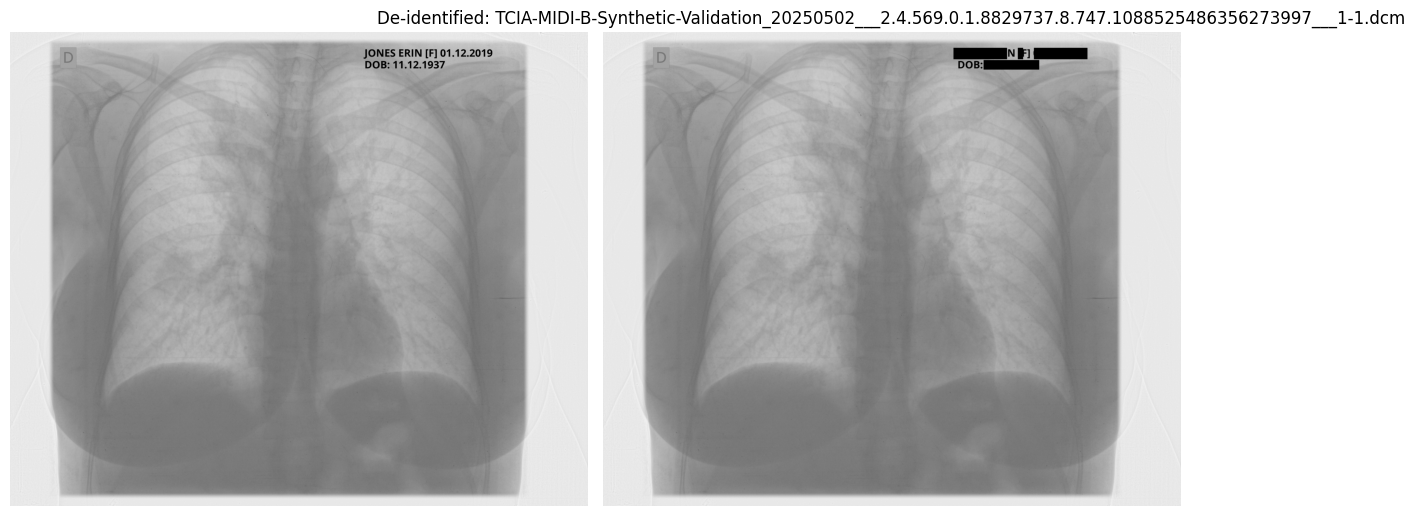

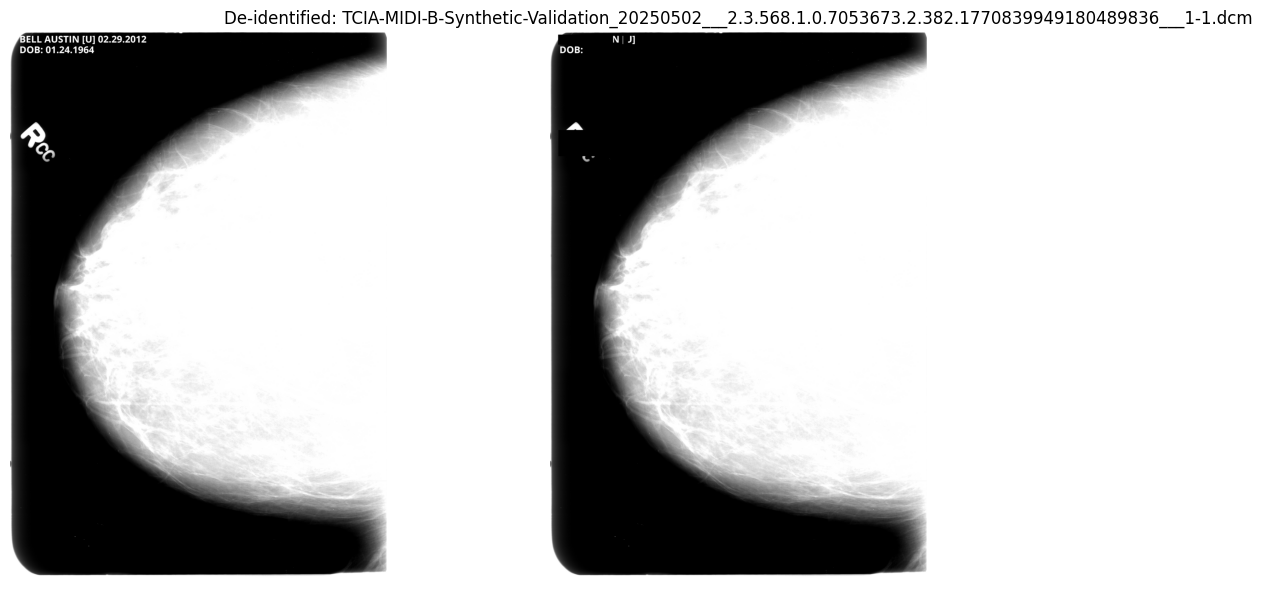

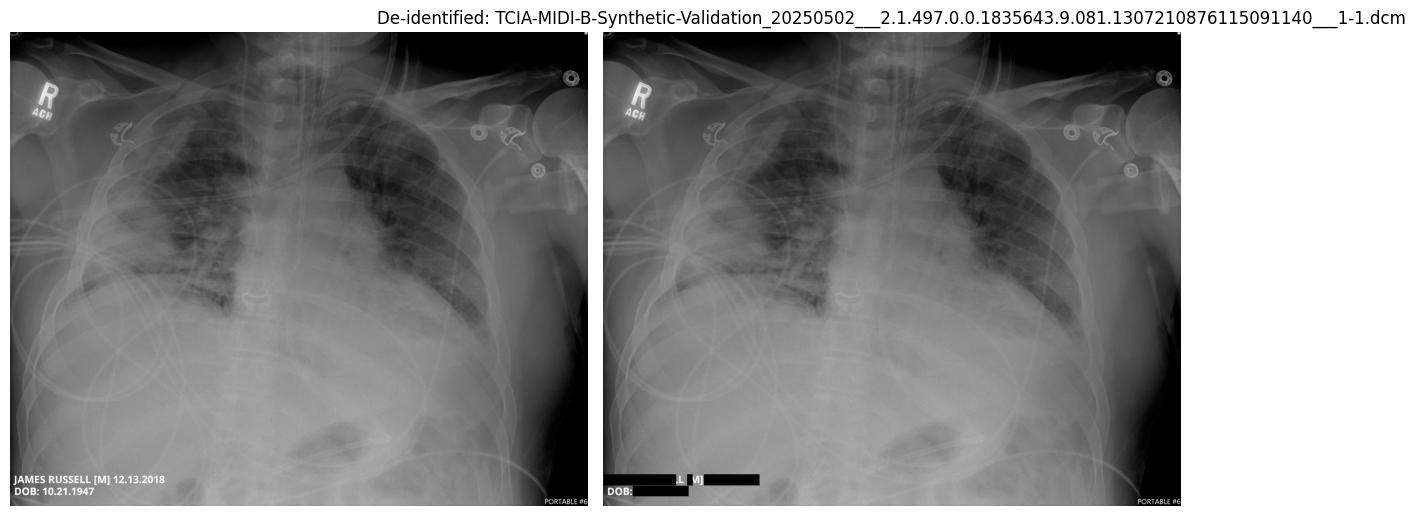

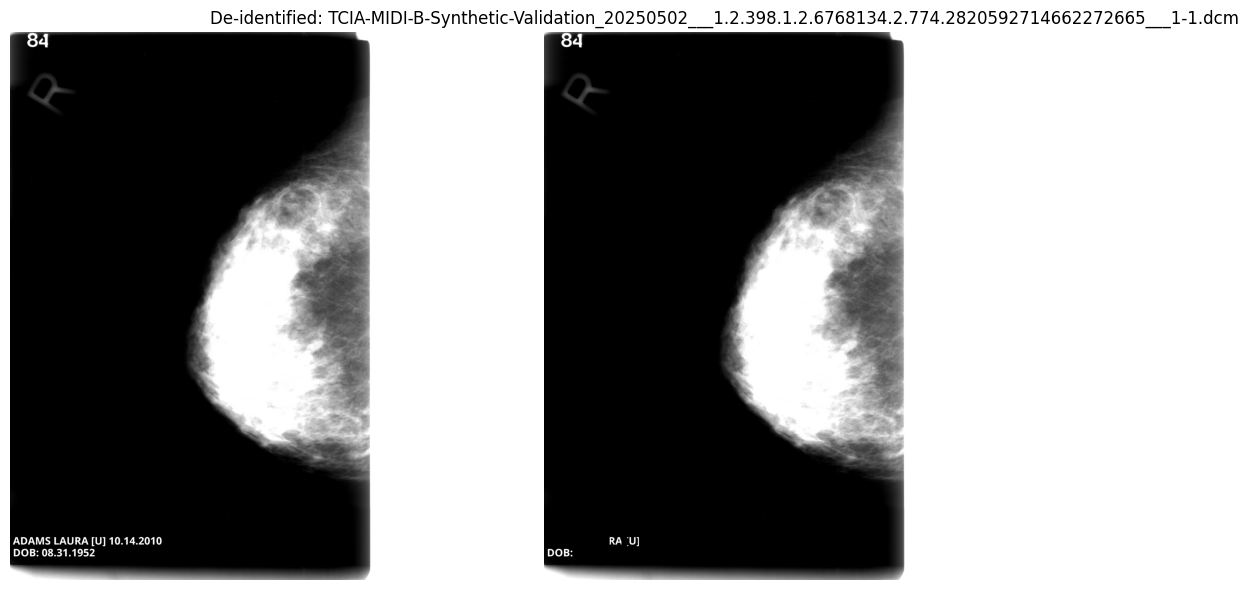

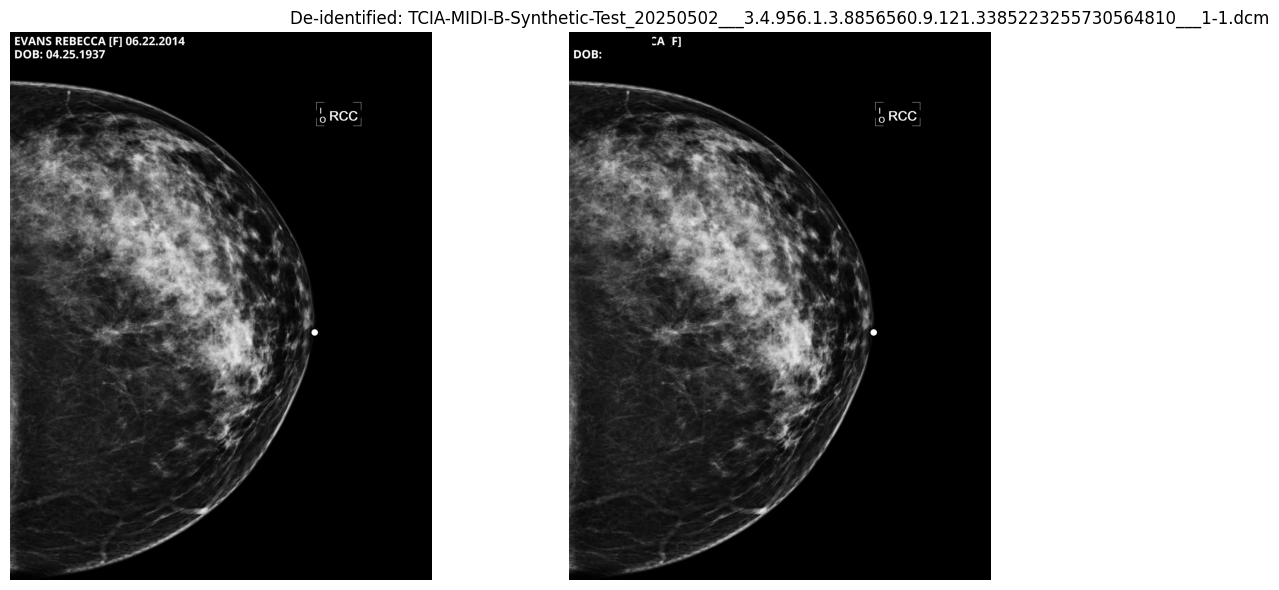

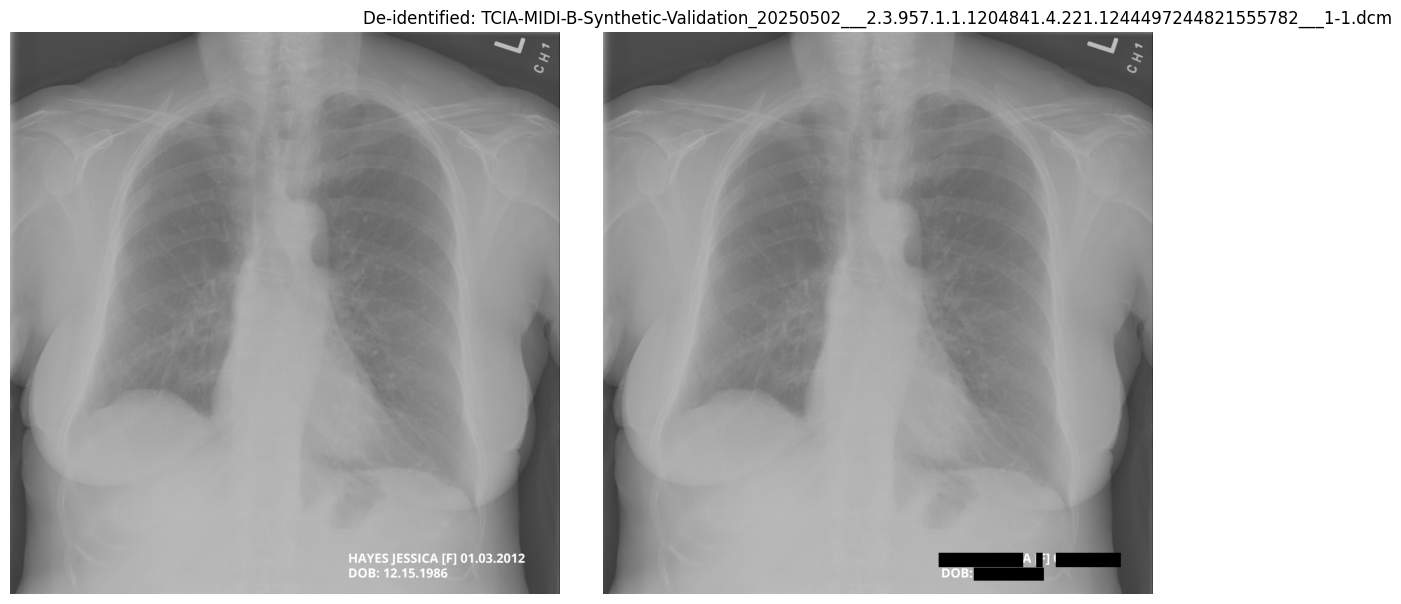

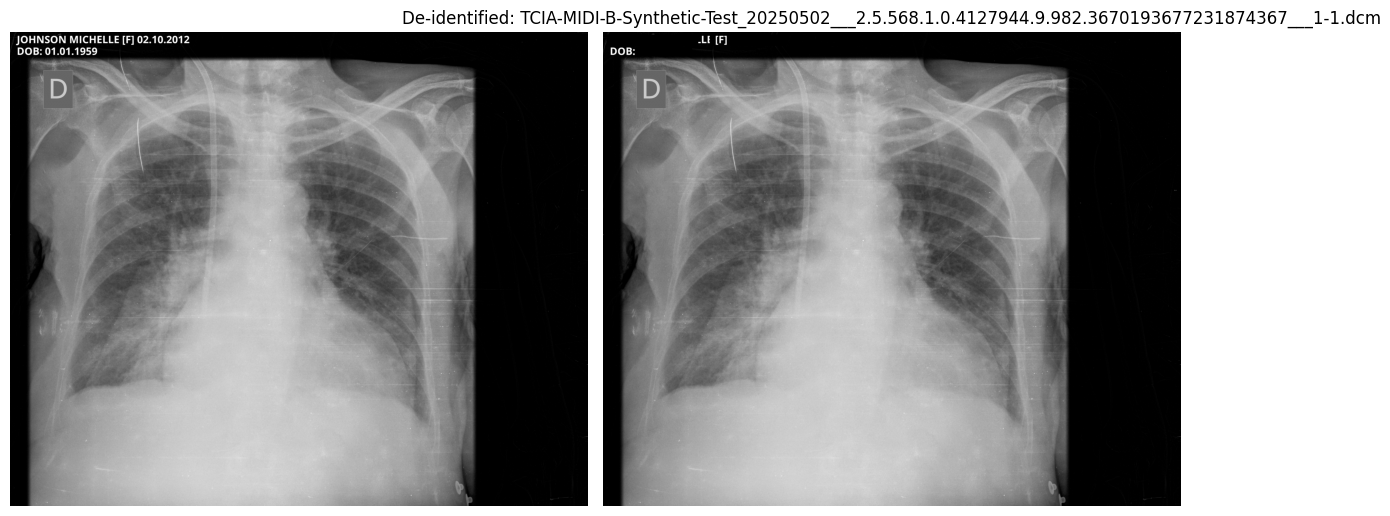

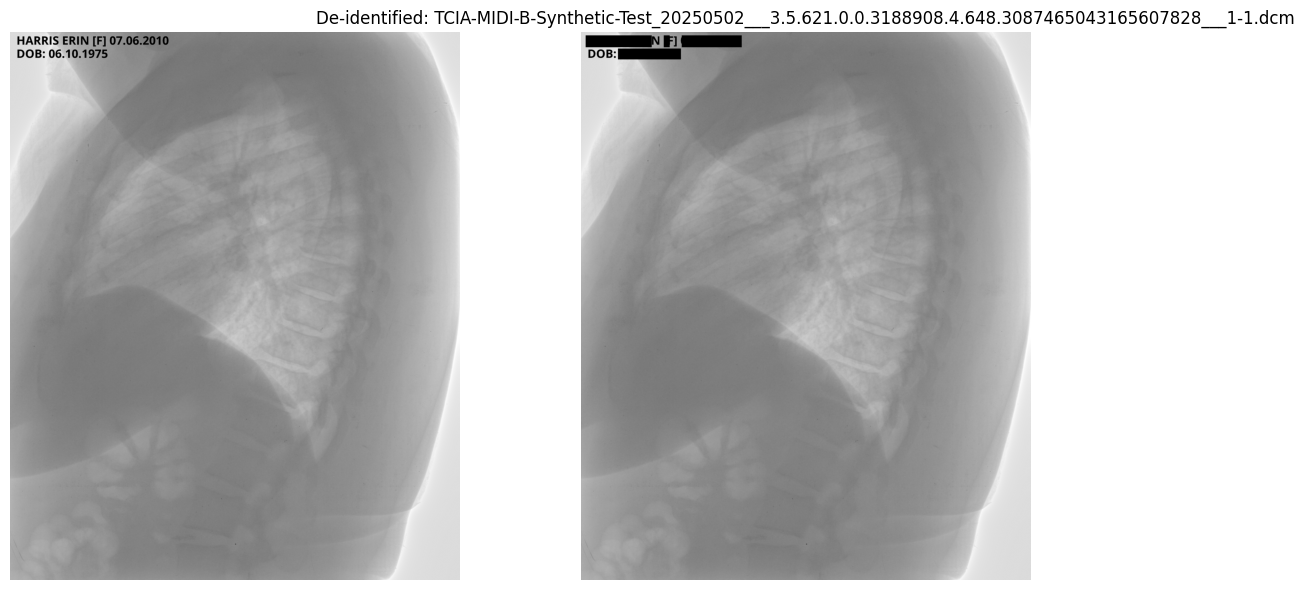

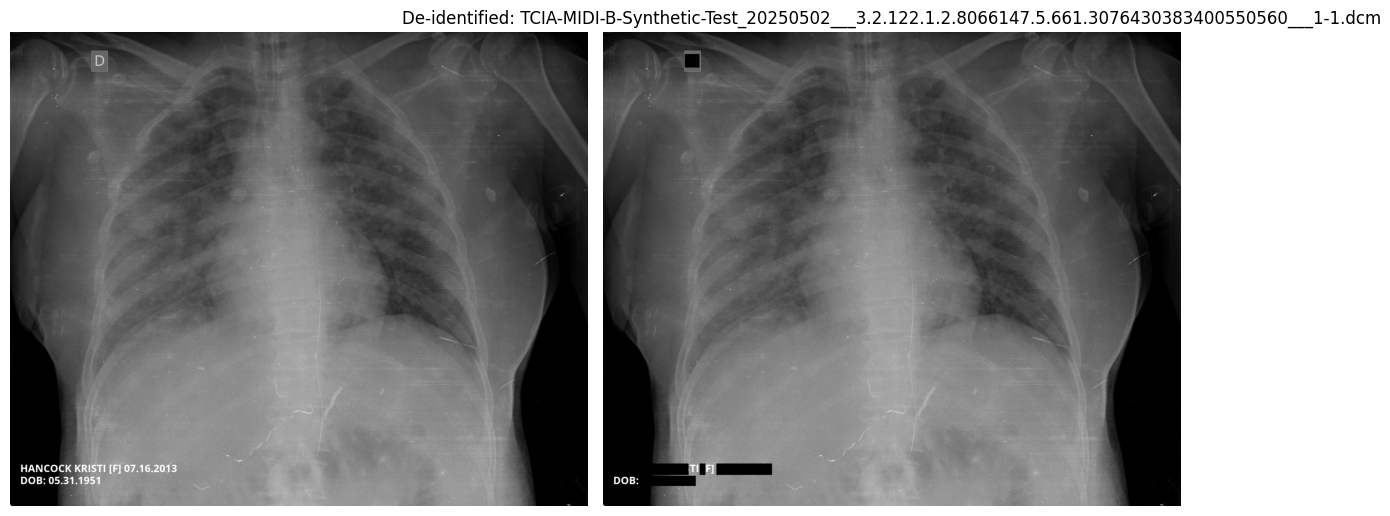

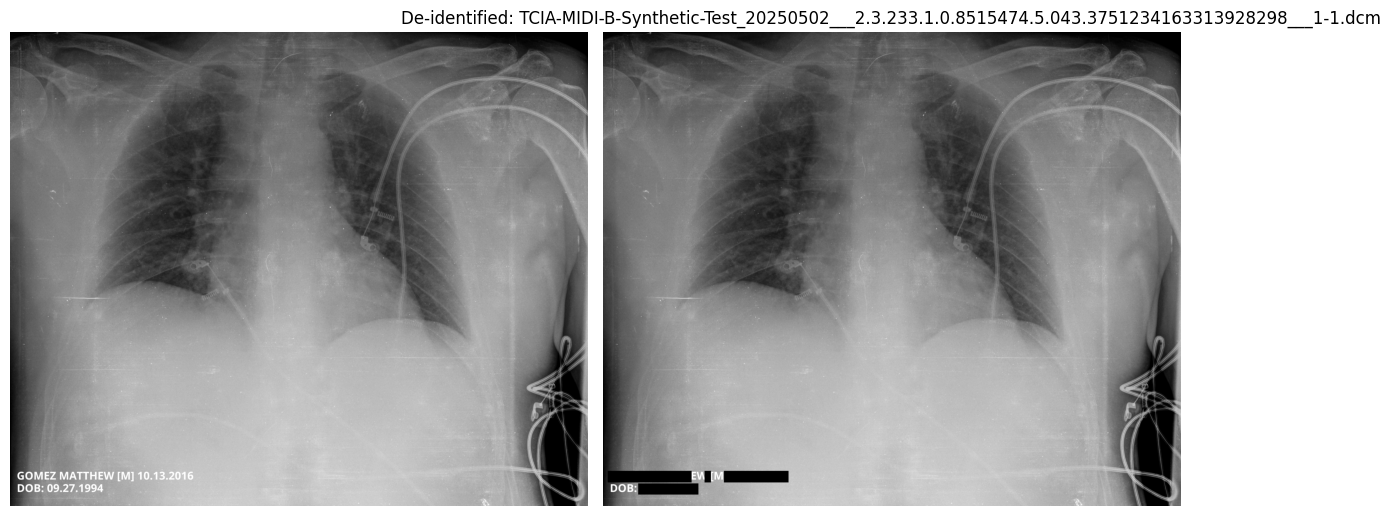

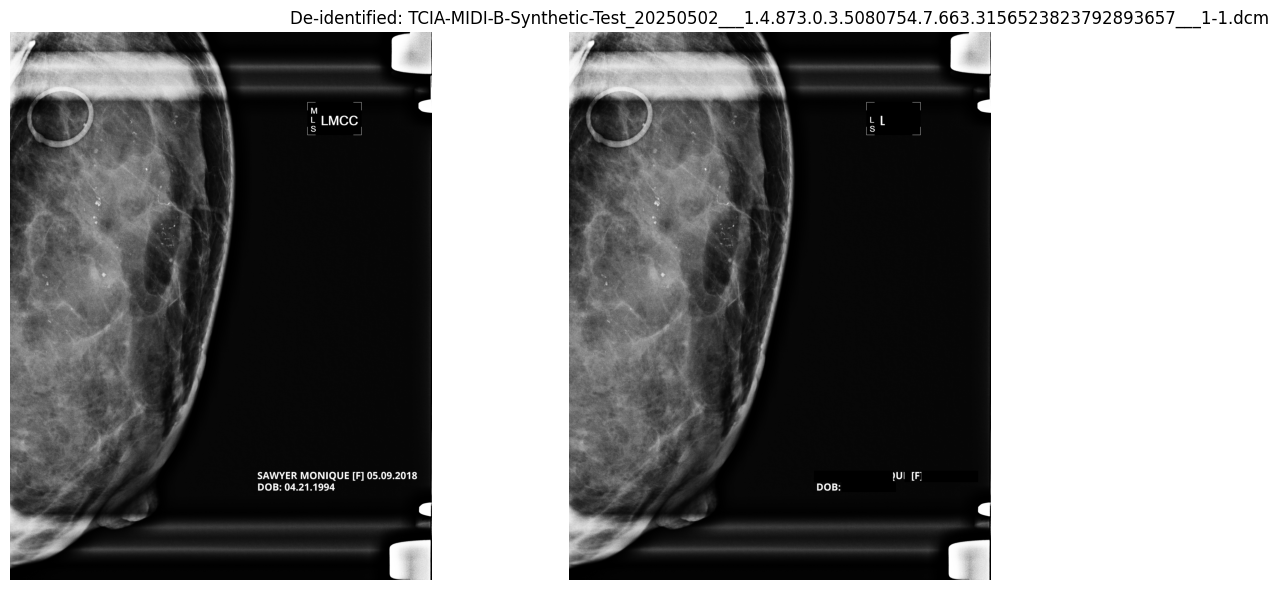

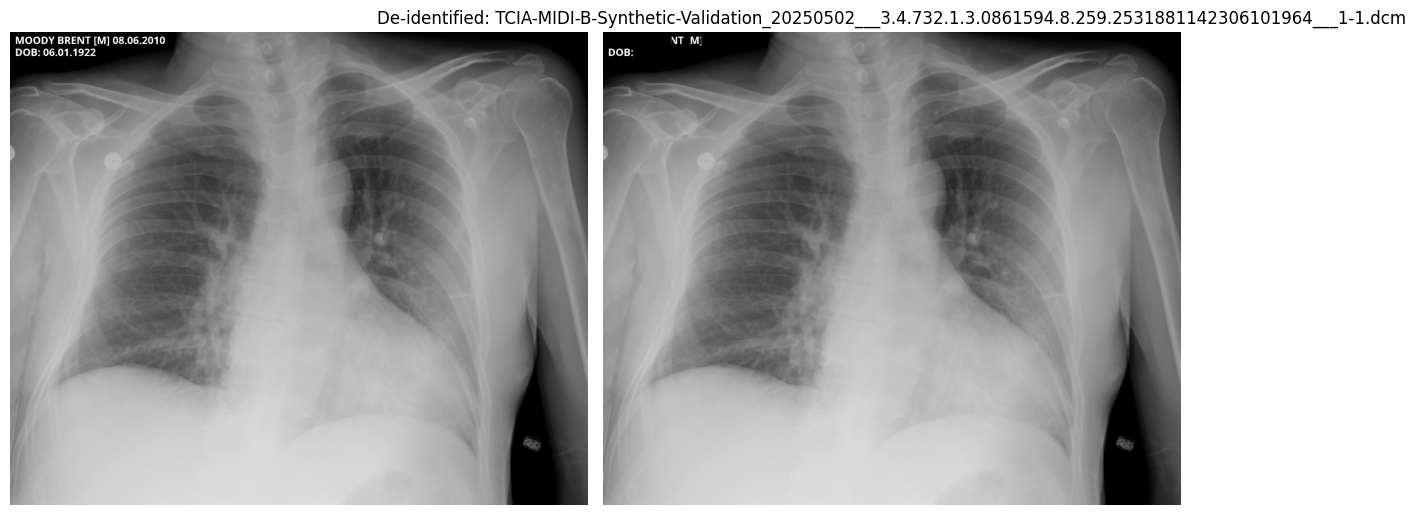

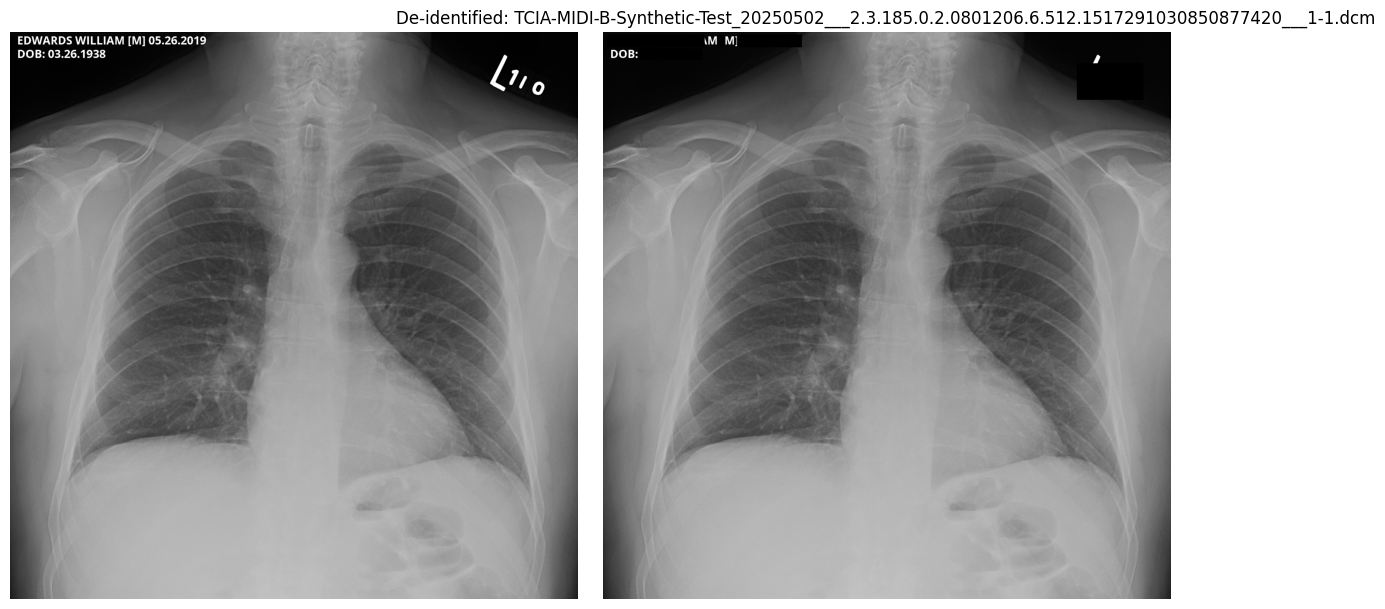

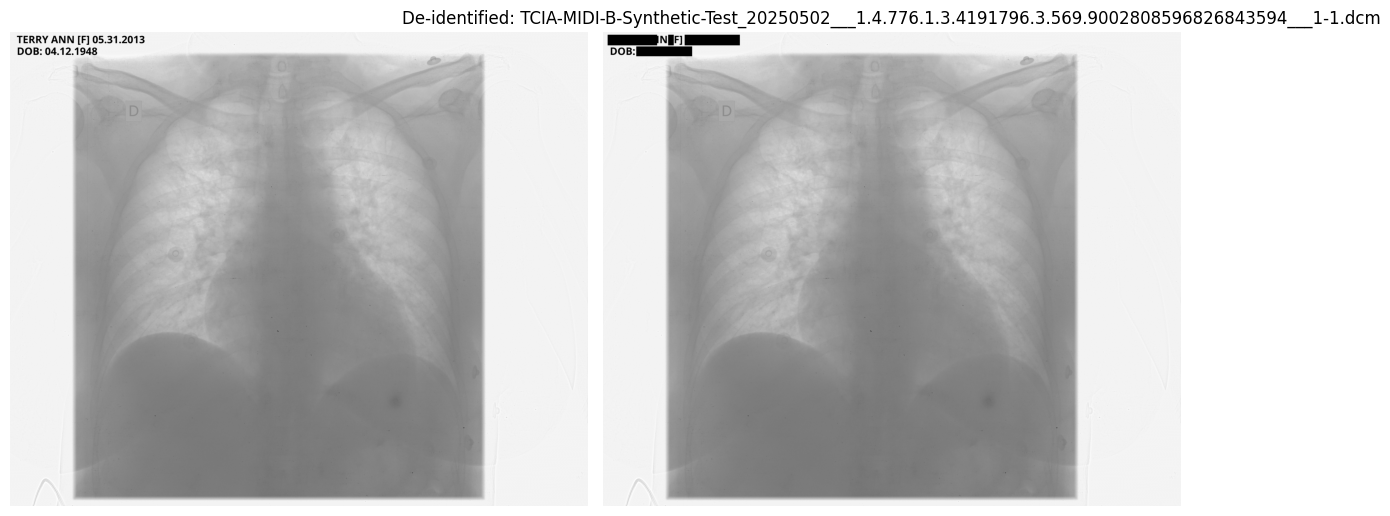

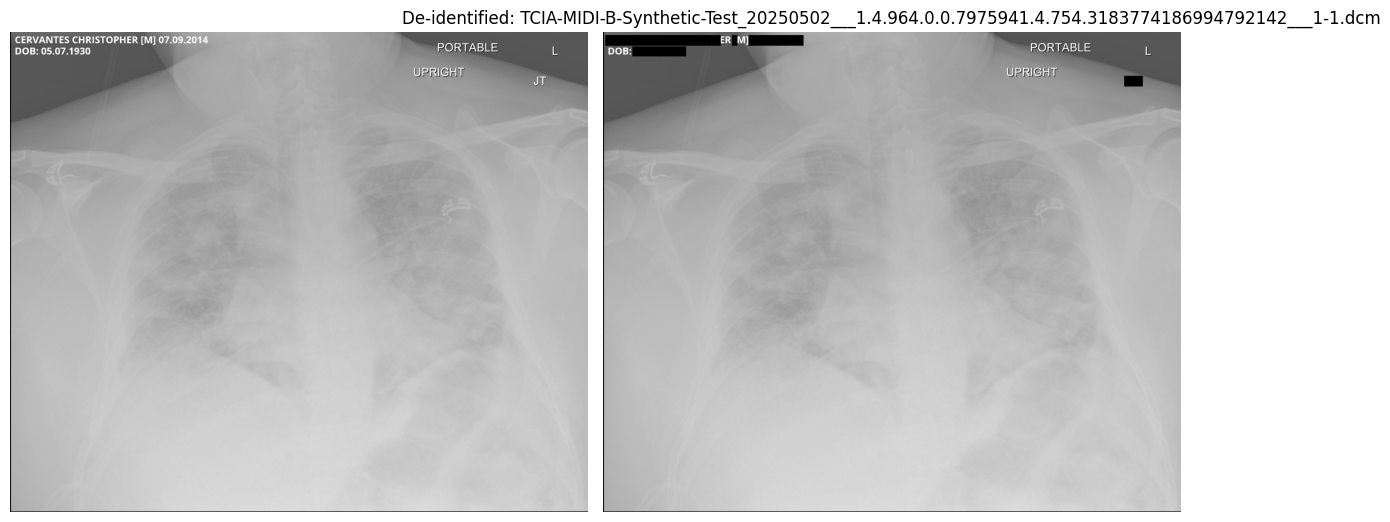

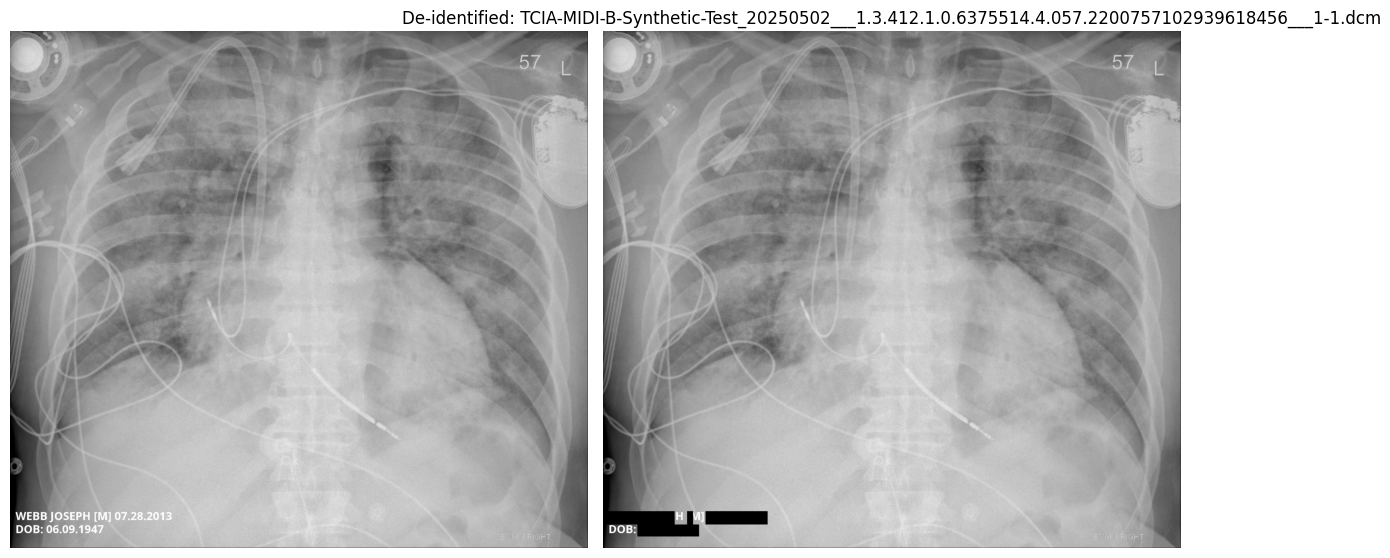

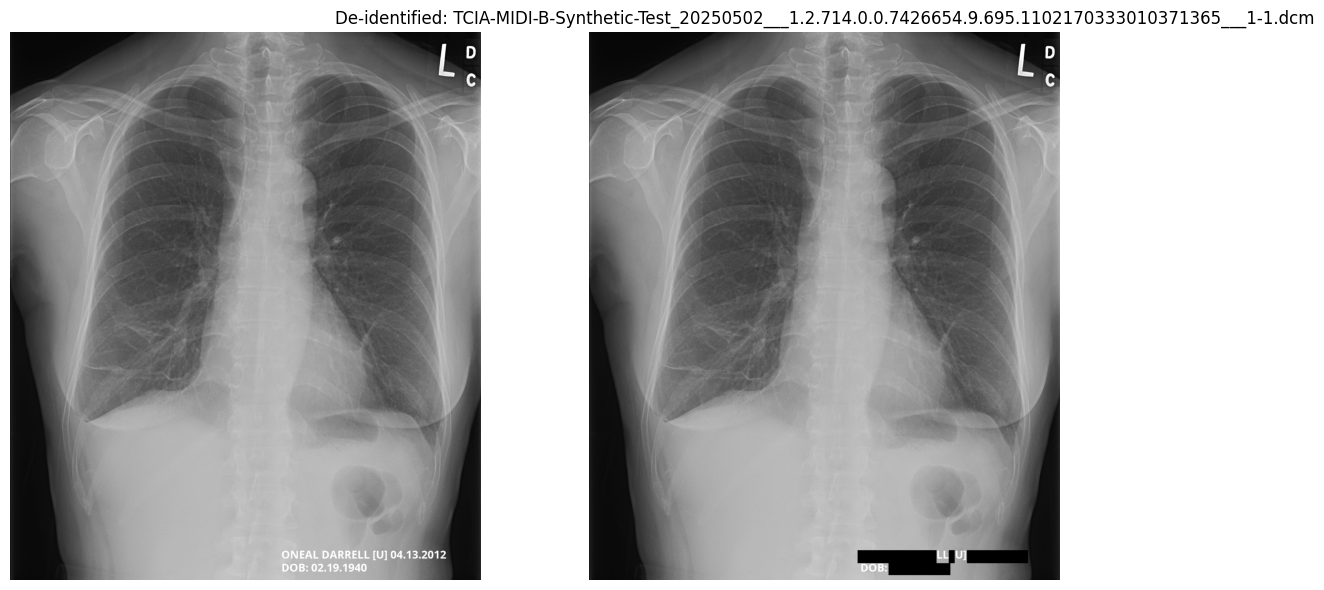

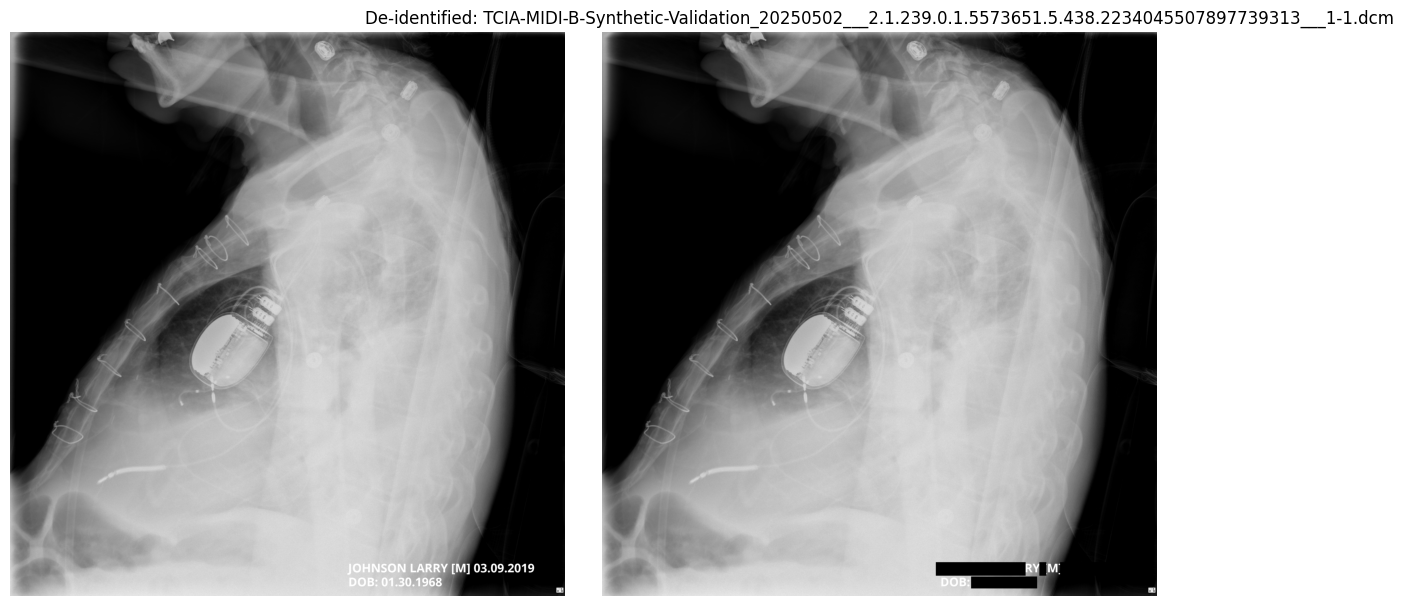

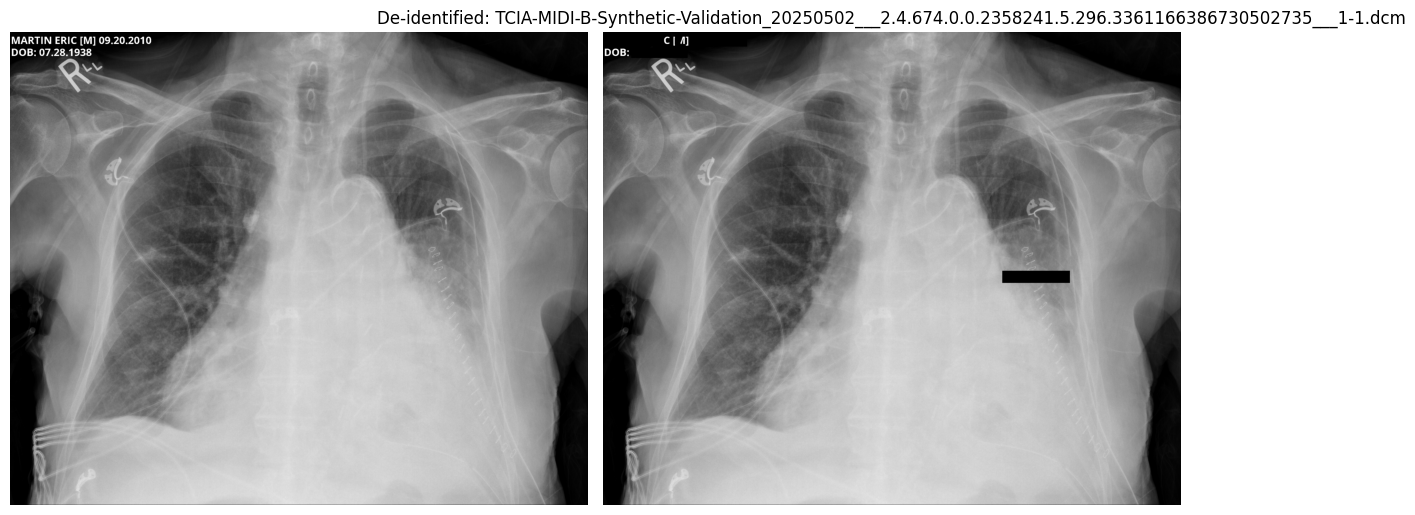

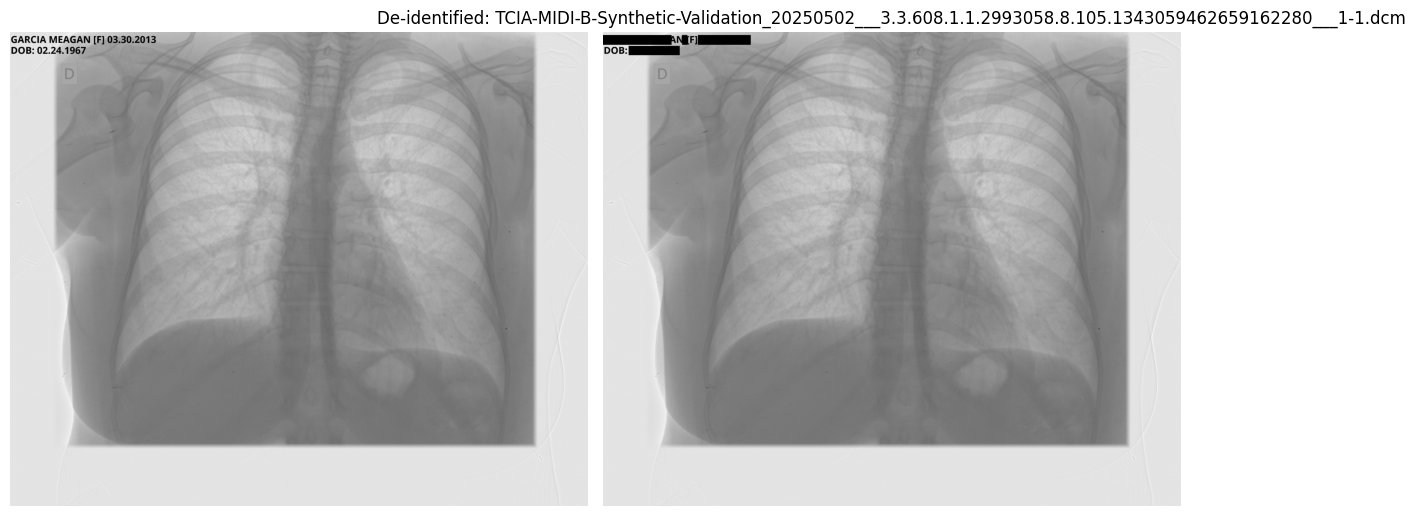

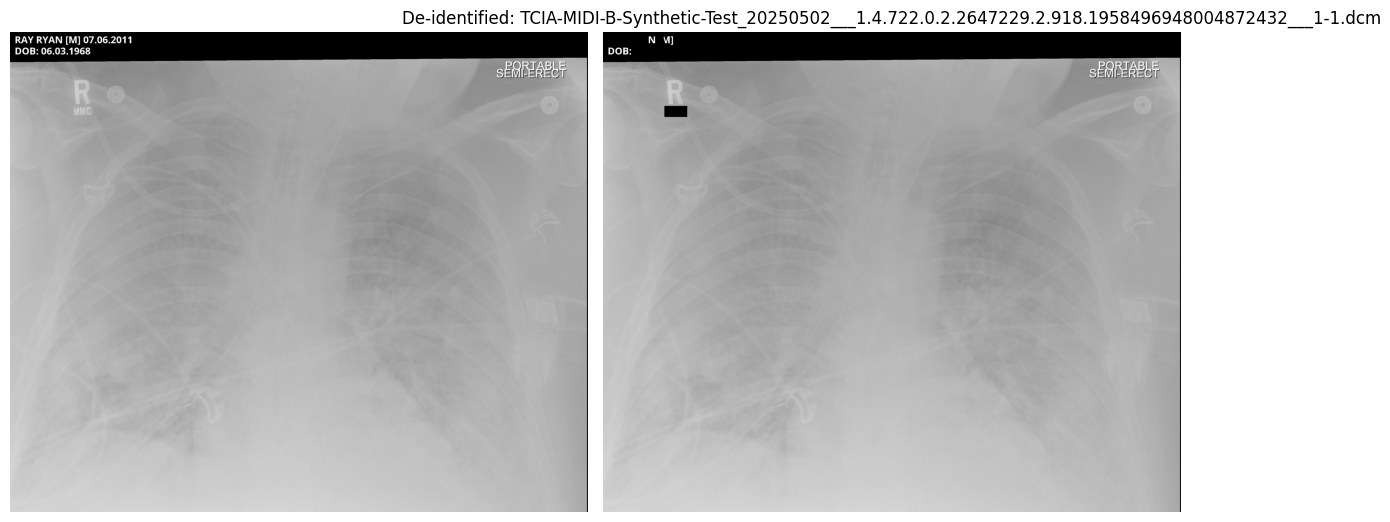

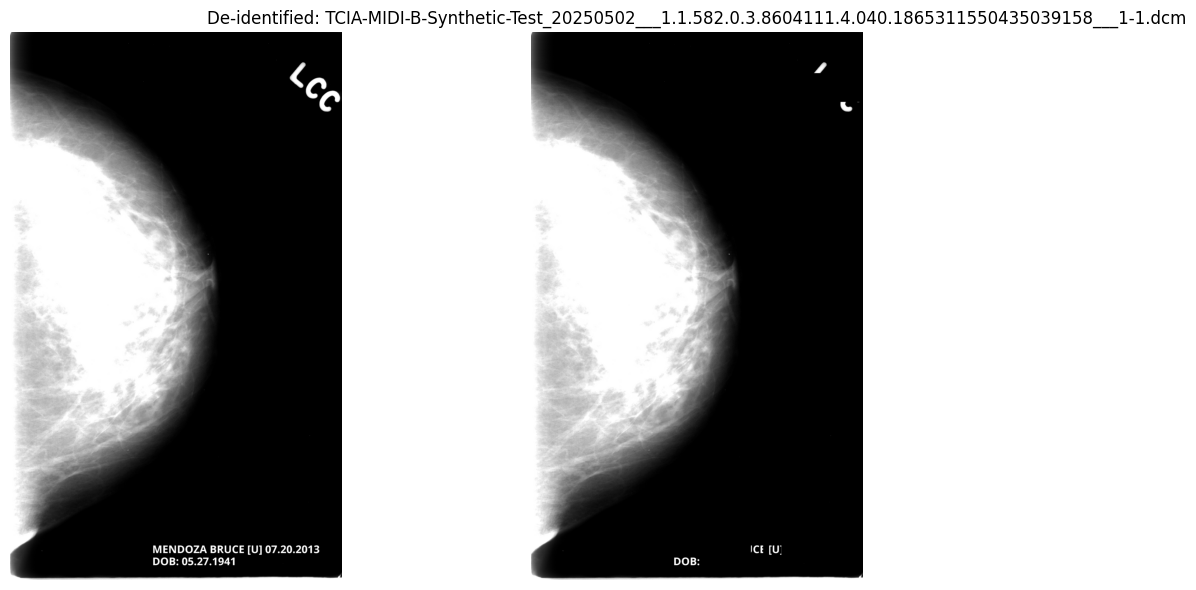

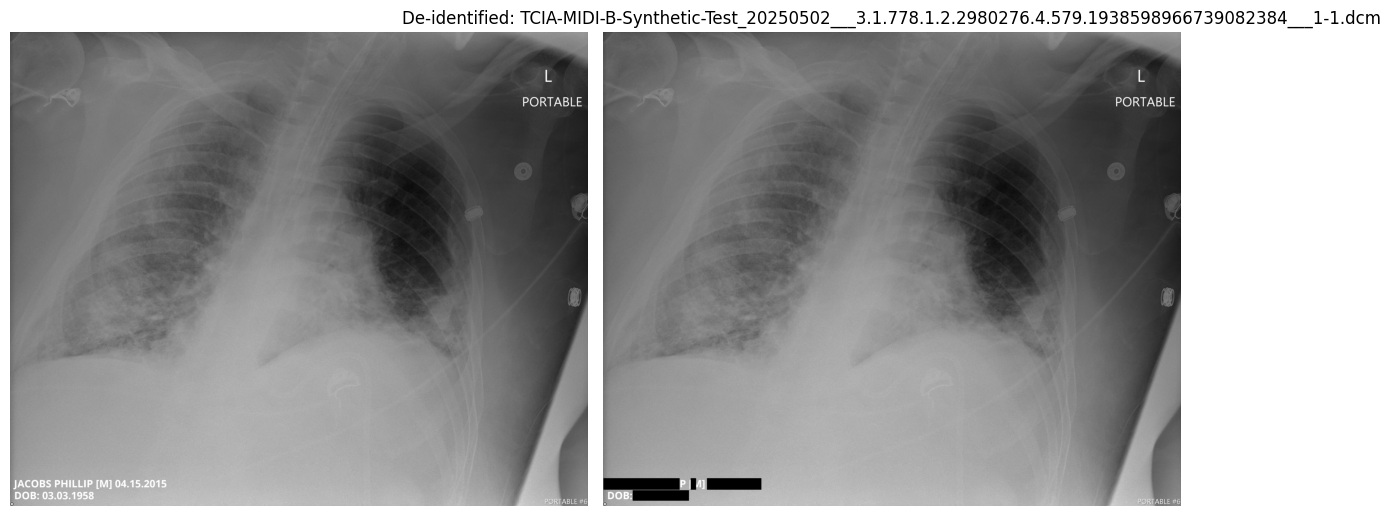

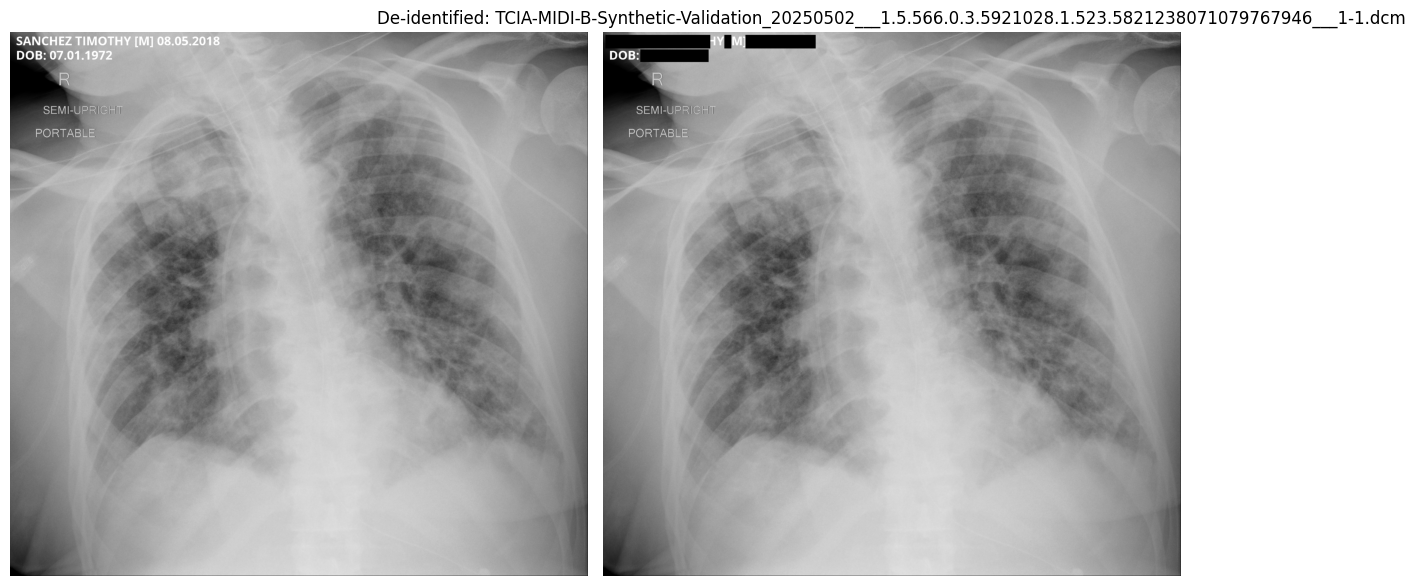

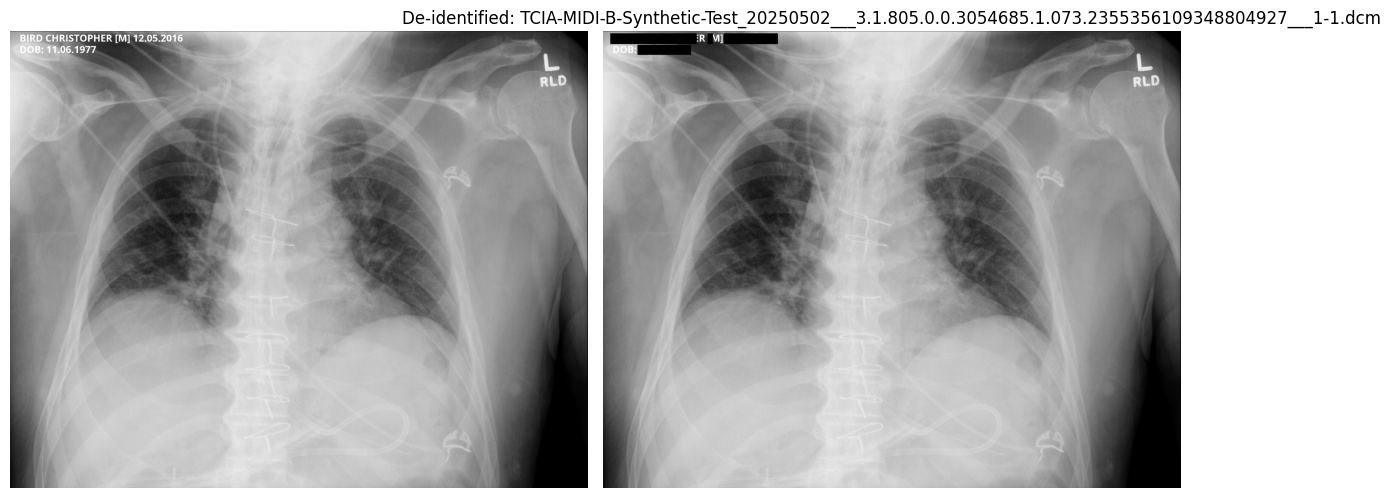

In [34]:
import os
import pydicom
import matplotlib.pyplot as plt

original_dicom_path = "./data/visual/dicom/midib"
deid_dicom_path = "./deid_dicom_files"

dicom_files = [f for f in os.listdir(original_dicom_path) if f.endswith(".dcm")]

for file in dicom_files:
    source_path = os.path.join(original_dicom_path, file)
    deid_path = os.path.join(deid_dicom_path, file)

    original = pydicom.dcmread(source_path)
    deid = pydicom.dcmread(deid_path)

    img_original = original.pixel_array
    img_deid = deid.pixel_array

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img_original, cmap="gray")
    axs[0].axis("off")

    axs[1].imshow(img_deid, cmap="gray")
    axs[1].set_title(f"De-identified: {file}")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

In [35]:
import shutil

shutil.rmtree("./deid_dicom_files")
shutil.rmtree("./temp_deid_ocr_results")
shutil.rmtree("./deid_dicom_result")
shutil.rmtree("./temp_ocr_results")